In [ ]:
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset

c:\Users\jkoro\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_layer_embeddings(model, tokenizer, sentences, max_length=512, batch_size=16):
    all_layers_embeddings = []
    num_batches = (len(sentences) + batch_size - 1) // batch_size

    for batch_idx in tqdm(range(num_batches)):
        batch_sentences = sentences[batch_idx * batch_size: (batch_idx + 1) * batch_size]

        inputs = tokenizer(batch_sentences, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        hidden_states = outputs.hidden_states

        for i in range(len(batch_sentences)):
            embeddings = [state[i].detach() for state in hidden_states]
            all_layers_embeddings.append(embeddings)

    return all_layers_embeddings


def average_cosine_similarity(embeddings, batch_size=16, ):
    avg_similarities = []
    num_layers = len(embeddings[0])
    for layer in tqdm(range(1, num_layers)):
        layer_vectors = [sentence[layer].to(device) for sentence in embeddings]

        num_batches = (len(layer_vectors) + batch_size - 1) // batch_size
        random_sims = []

        for batch_idx in range(num_batches):
            batch_vecs = layer_vectors[batch_idx * batch_size: (batch_idx + 1) * batch_size]

            for vecs in batch_vecs:
                idx1, idx2 = np.random.choice(len(vecs), 2, replace=False)
                vec1, vec2 = vecs[idx1], vecs[idx2]
                sim = torch.nn.functional.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0), dim=-1)
                random_sims.append(sim.item())

        avg_similarities.append(np.mean(random_sims))
    return avg_similarities

def self_similarity(embeddings, baseline, batch_size=16, ):
    self_sims = []
    num_layers = len(embeddings[0])

    for layer in tqdm(range(1, num_layers)):
        layer_vectors = [sentence[layer].to(device) for sentence in embeddings]

        num_batches = (len(layer_vectors) + batch_size - 1) // batch_size
        sims = []

        for batch_idx in range(num_batches):
            batch_vecs = layer_vectors[batch_idx * batch_size: (batch_idx + 1) * batch_size]

            for vecs in batch_vecs:
                sim_matrix = torch.nn.functional.cosine_similarity(vecs.unsqueeze(1), vecs.unsqueeze(0), dim=-1)
                mask = ~torch.eye(sim_matrix.size(0), device=device, dtype=bool)
                sims.append(sim_matrix[mask].mean().item())

        self_sims.append(np.mean(sims) - baseline[layer - 1])
    return self_sims

def intra_sentence_similarity(embeddings, baseline, batch_size=16, ):
    intra_sims = []
    num_layers = len(embeddings[0])

    for layer in tqdm(range(1, num_layers)):
        layer_vectors = [sentence[layer].to(device) for sentence in embeddings]

        num_batches = (len(layer_vectors) + batch_size - 1) // batch_size
        sims = []

        for batch_idx in range(num_batches):
            batch_vecs = layer_vectors[batch_idx * batch_size: (batch_idx + 1) * batch_size]

            for vecs in batch_vecs:
                sentence_mean = vecs.mean(dim=0)
                norm_vecs = vecs / vecs.norm(dim=1, keepdim=True)
                norm_mean = sentence_mean / sentence_mean.norm()
                similarities = torch.matmul(norm_vecs, norm_mean)
                sims.extend(similarities.cpu().numpy())

        intra_sims.append(np.mean(sims) - baseline[layer - 1])
    return intra_sims

# 5. Wykres
def plot_metric(layers, bert_metric, gpt2_metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(layers, bert_metric, label="BERT", marker='o', linestyle='-')
    plt.plot(layers, gpt2_metric, label="GPT-2", marker='s', linestyle='--')
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
batch_size = 16

In [7]:
device

device(type='cpu')

In [4]:
dataset = load_dataset("clarin-knext/wsd_polish_datasets", split="train", trust_remote_code=True)
sample_texts = dataset["text"][:100]

In [ ]:
# Załadowanie modeli
bert_model_name = "bert-base-multilingual-cased"
gpt2_model_name = "flax-community/papuGaPT2"


In [8]:
bert_model = AutoModel.from_pretrained(bert_model_name, output_hidden_states=True)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

gpt2_model = AutoModel.from_pretrained(gpt2_model_name, output_hidden_states=True)
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  

In [11]:
bert_embeddings = get_layer_embeddings(bert_model, bert_tokenizer, sample_texts, batch_size=batch_size)
gpt2_embeddings = get_layer_embeddings(gpt2_model, gpt2_tokenizer, sample_texts, batch_size=batch_size)

100%|██████████| 7/7 [00:42<00:00,  6.09s/it]


In [12]:
bert_baseline = average_cosine_similarity(bert_embeddings, batch_size=batch_size)
gpt2_baseline = average_cosine_similarity(gpt2_embeddings, batch_size=batch_size)

bert_self_sim = self_similarity(bert_embeddings, bert_baseline, batch_size=batch_size)
gpt2_self_sim = self_similarity(gpt2_embeddings, gpt2_baseline, batch_size=batch_size)

bert_intra_sim = intra_sentence_similarity(bert_embeddings, bert_baseline, batch_size=batch_size)
gpt2_intra_sim = intra_sentence_similarity(gpt2_embeddings, gpt2_baseline, batch_size=batch_size)

100%|██████████| 12/12 [00:00<00:00, 18.56it/s]


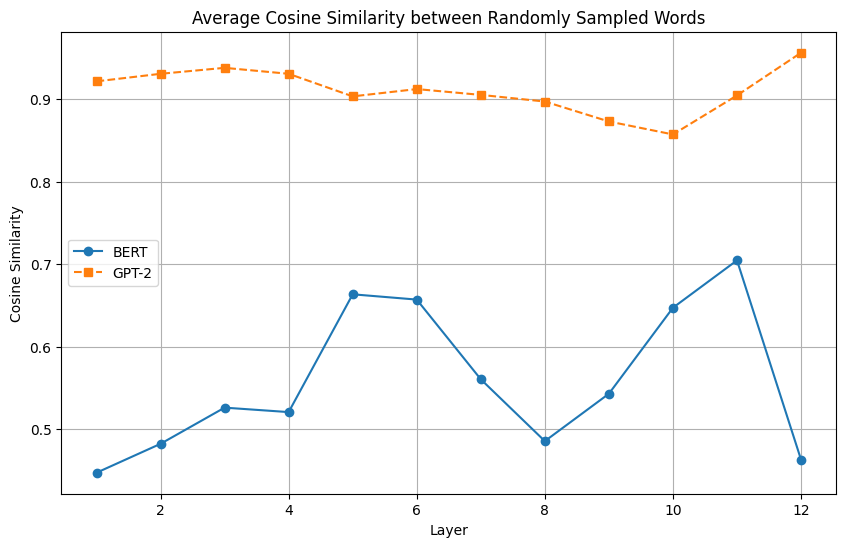

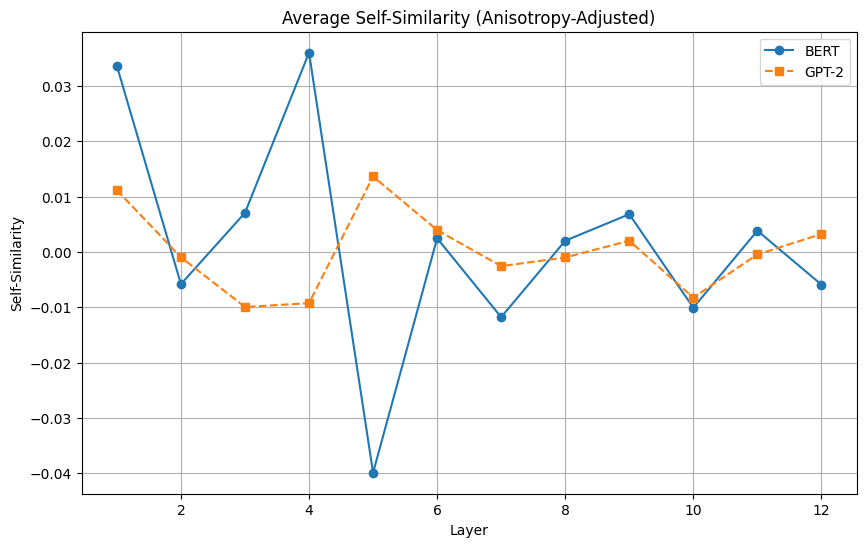

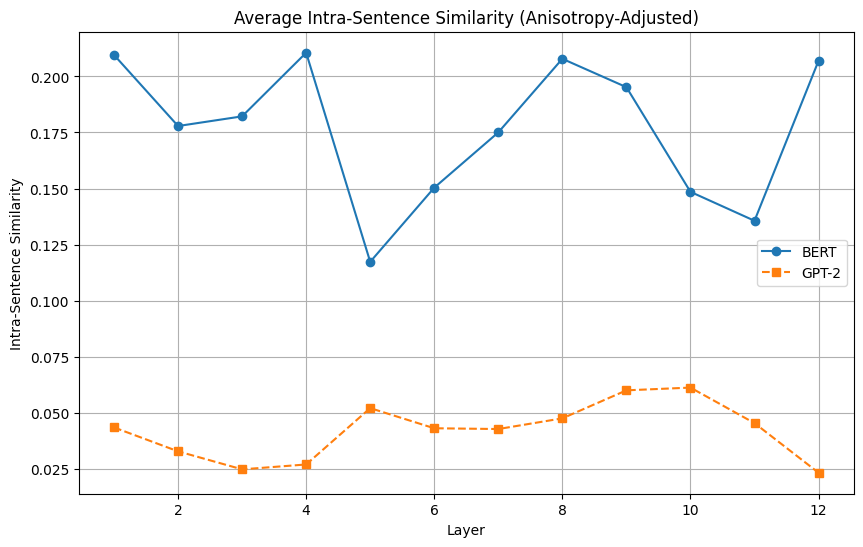

In [14]:
layers = list(range(1, 13))
plot_metric(layers, bert_baseline, gpt2_baseline, "Average Cosine Similarity between Randomly Sampled Words", "Cosine Similarity")
plot_metric(layers, bert_self_sim, gpt2_self_sim, "Average Self-Similarity (Anisotropy-Adjusted)", "Self-Similarity")
plot_metric(layers, bert_intra_sim, gpt2_intra_sim, "Average Intra-Sentence Similarity (Anisotropy-Adjusted)", "Intra-Sentence Similarity")